In [30]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import plasma, hsv
from matplotlib.patches import Ellipse
from scipy.io import loadmat

from noise_correlations.data import datasets

In [104]:
# data paths
fname = 'nc_datasets/R32_B7_HG_ext_rsp.h5'
with h5py.File(fname, 'r') as f:
    resp = f['final_rsp'].value
n_el, n_samples, n_freq, n_attn = resp.shape
Yp = np.transpose(resp[..., 5], axes=(0, 2, 1))
trial_medians = abs(np.median(Yp, axis=-1))
keep = (trial_medians.max(axis=1) - trial_medians.min(axis=1)) >= 5.
Yp = Yp[keep]
bfs = np.median(Yp, axis=-1).argmax(axis=1)
idxs = np.argsort(bfs)
bfs = bfs[idxs]
Yp_fs = Yp[idxs]

In [105]:
trial_medians.max(axis=1) - trial_medians.min(axis=1)

array([4.77743047, 2.39340329, 2.7883136 , 4.50288538, 2.29093618,
       2.24842785, 2.5059719 , 4.20474976, 3.99595002, 2.40781177,
       0.22211335, 1.6336057 , 0.31388256, 2.49230592, 1.74506426,
       5.42516565, 3.90457131, 3.58310772, 1.77235412, 2.55221993,
       1.80750767, 2.36573715, 1.96337681, 3.91790962, 3.74840795,
       5.93356523, 6.2888178 , 6.48430994, 7.1620431 , 5.00666691,
       5.14703471, 2.47301427, 2.43503317, 5.94555598, 4.50955732,
       6.93354068, 5.89969452, 6.85470821, 6.84257666, 5.1735028 ,
       8.5535133 , 6.72341966, 8.07614255, 6.24814385, 7.43836101,
       3.21191755, 4.33870306, 9.7166537 , 6.24891015, 7.93928529,
       6.61671188, 3.35093224, 5.45487461, 4.31174603, 5.53435308,
       5.75430596, 3.22739924, 5.74491882, 6.03974632, 5.81465879])

In [106]:
Yp.shape

(28, 30, 20)

IndexError: index 28 is out of bounds for axis 0 with size 28

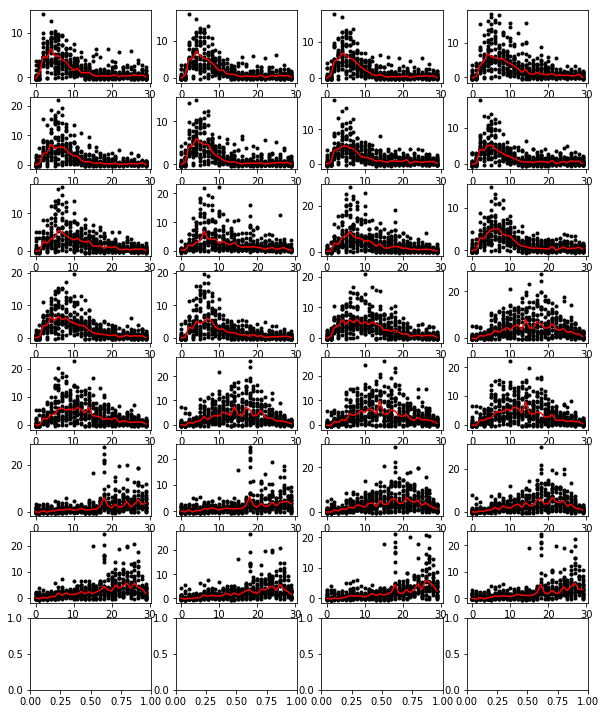

In [109]:
fig, axes = plt.subplots(1 + Yp_fs.shape[0]//4, 4, figsize=(10, 12.5))
for ax_idx, ax in enumerate(axes.ravel()):
    counts = Yp_fs[ax_idx]
    freqs = np.tile(np.arange(n_freq)[:, np.newaxis], (1, Yp.shape[-1]))
    ax.scatter(freqs, counts, marker='.', color='k')
    ax.plot(np.median(freqs, axis=1), np.median(counts, axis=1), color='r')

In [156]:
axes_label_size = 14
title_size = 20
plot_label_size = 14

def plot_3(Y, X, axes, e_idxs, wrap=False, logspace=False, left=True, bottom=True, scatter=False):
    axa, axb, axc = axes
    if wrap:
        cm = hsv
    else:
        cm = plasma
    cm_locs = np.linspace(0, 1, Y.shape[1], endpoint=False)[np.newaxis]
    for ii in range(Y.shape[1]):
        xi = Y[0, ii]
        yi = Y[1, ii]
        if (ii % 2) == 0:
            mu = np.mean(Y[:, ii], axis=1)
            cov = np.cov(xi, yi, rowvar=False)
            e, v = np.linalg.eigh(cov)
            e = np.sqrt(e) * 2.
            ell = Ellipse(mu, e[1], e[0],
                          180. * np.arctan2(v[1, -1], v[0, -1]) / np.pi,
                          facecolor='none', edgecolor=cm(cm_locs[0, ii]))
            axa.add_artist(ell)
        if scatter:
            axa.scatter(xi, yi, s=1., c=cm(cm_locs[:, ii]))
        axb.scatter(np.tile(X[ii], Y.shape[-1]), Y[0, ii], s=1., c=cm(cm_locs[:, ii]))
        axc.scatter(Y[1, ii], np.tile(X[ii], Y.shape[-1]), s=1., c=cm(cm_locs[:, ii]))
    extent = 2. * Y.mean(axis=-1).max(axis=1)
    axa.set_xlim(-1, np.around(extent[0]))
    axa.set_ylim(-1, np.around(extent[1]))
    axa.set_xticks([0, int(np.around(extent[0]))])
    axa.set_yticks([0, int(np.around(extent[1]))])
    axa.plot(*Y.mean(axis=-1), c='k')
    if logspace:
        axb.set_xscale('log')
        axc.set_yscale('log')
    if not left:
        axa.invert_xaxis()
        axc.invert_xaxis()
        axa.yaxis.set_label_position("right")
        axa.yaxis.tick_right()
    else:
        axc.yaxis.set_label_position("right")
        axc.yaxis.tick_right()
    if not bottom:
        axa.invert_yaxis()
        axb.invert_yaxis()
        axa.xaxis.set_label_position("top")
        axa.xaxis.tick_top()
    else:
        axb.xaxis.set_label_position("top")
        axb.xaxis.tick_top()

    axb.plot(X, Y[0].mean(axis=-1), c='k')
    axc.plot(Y[1].mean(axis=-1), X, c='k')
    axa.set_xlabel(r'$e_{}{}{}$'.format('{', e_idxs[0], '}'), size=axes_label_size, labelpad=-5)
    axa.set_ylabel(r'$e_{}{}{}$'.format('{', e_idxs[1], '}'), size=axes_label_size, labelpad=-5)
    axb.set_xlabel('Freq (Hz)', size=axes_label_size)
    axb.set_ylabel(r'$e_{}{}{}$'.format('{', e_idxs[0], '}'), size=axes_label_size)
    axc.set_xlabel(r'$e_{}{}{}$'.format('{', e_idxs[1], '}'), size=axes_label_size)
    axc.set_ylabel('Freq (Hz)', size=axes_label_size)

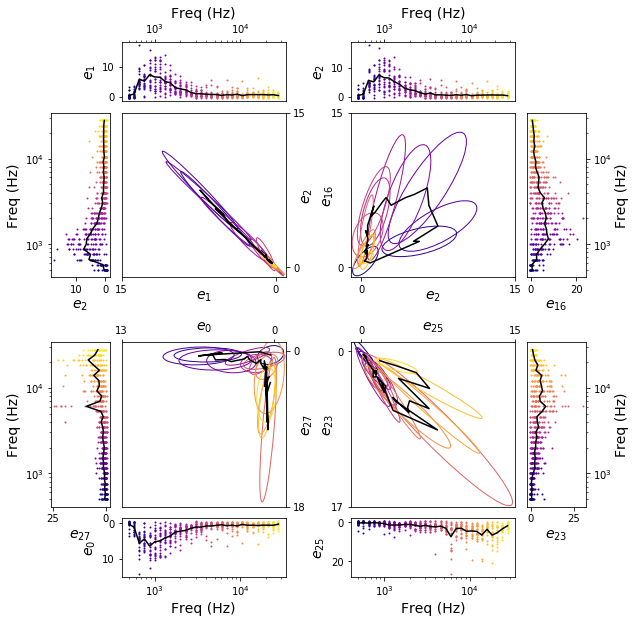

In [158]:
figsize=(9, 9)
f = plt.figure(figsize=figsize)

le = .075
be = .1
re = .1
hg = .1
vg = hg * figsize[0] / figsize[1]

sub_w = (1. - le - re - hg) / 2.
sub_h = sub_w * figsize[0] / figsize[1]

inset_w = .7 * sub_w
inset_h = inset_w * figsize[0] / figsize[1]
inset_gap_w = .05 * sub_w
inset_gap_h = inset_gap_w * figsize[0] / figsize[1]
inset_small_w = (sub_w - inset_w - inset_gap_h)
inset_small_h = inset_small_w * figsize[0] / figsize[1]

axes = []
idx_vals = np.arange(Yp_fs.shape[0])
idxs = [[1, 2], [2, 16], [0, idx_vals[-1]], [idx_vals[-3], idx_vals[-5]]]
idx = 0
for bottom in [1, 0]:
    for left in [0, 1]:
        my_le = le + (sub_w + hg) * left
        my_be = be + (sub_h + vg) * bottom
        axa = f.add_axes([my_le + (inset_small_w + inset_gap_w) * (1 - left),
                          my_be + (inset_small_h + inset_gap_h) * (1 - bottom),
                          inset_w, inset_h])
        axb = f.add_axes([my_le + (inset_small_w + inset_gap_w) * (1 - left),
                          my_be + (inset_h + inset_gap_h) * bottom,
                          inset_w, inset_small_h])
        axc = f.add_axes([my_le + (inset_w + inset_gap_w) * left,
                          my_be + (inset_small_h + inset_gap_h) * (1 - bottom),
                          inset_small_w, inset_h])

        Y = Yp_fs[idxs[idx]]
        plot_3(Y, np.logspace(np.log10(500), np.log10(32000), Y.shape[1], endpoint=False), [axa, axb, axc], e_idxs=idxs[idx],
               logspace=True, bottom=bottom, left=left)

        idx += 1


plt.savefig('stimuli_response.pdf', dpi=300)
plt.savefig('stimuli_response.png', dpi=300)

-1 [[0.52961765 0.51922048]
 [0.51922048 0.72494392]]
[0.09895514 1.15560644]
[[-0.76969281  0.63841443]
 [ 0.63841443  0.76969281]]
39.67368855487368
-12 [[ 0.5676217   2.15167324]
 [ 2.15167324 12.11074667]]
[ 0.1795875  12.49878087]
[[-0.98412482  0.17747773]
 [ 0.17747773  0.98412482]]
10.222878979443019
2 [[13.2086452   2.72827259]
 [ 2.72827259  2.20556554]]
[ 1.56622499 13.84798575]
[[ 0.22815806 -0.97362411]
 [-0.97362411 -0.22815806]]
-103.18865304643685


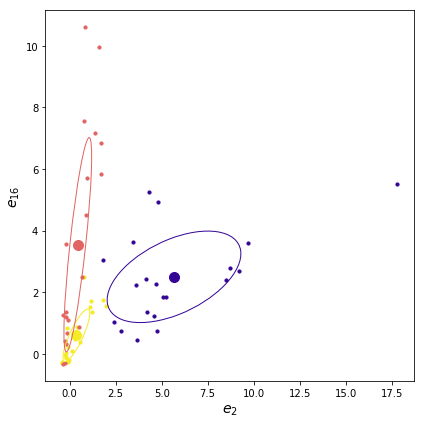

In [155]:
axes_label_size = 14
title_size = 20
plot_label_size = 14

f, ax = plt.subplots(1, figsize=(6, 6))

e_idxs = [2, 16]
f_idxs = [-1, -12, 2]

cm_locs = np.linspace(0, 1, Yp_fs.shape[1], endpoint=False)[np.newaxis]

for fid in f_idxs:
    Y = Yp_fs[e_idxs][:, fid]
    xi, yi = Y
    mu = np.mean(Y, axis=1)
    cov = np.cov(xi, yi, rowvar=False)
    print(fid, cov)
    e, v = np.linalg.eigh(cov)
    idxs = np.argsort(e)
    e = e[idxs]
    v = v[:, idxs]
    print(e)
    print(v)
    print(180. * np.arctan2(v[0, -1], v[1, -1]) / np.pi)
    e = np.sqrt(e) * 2.
    ell = Ellipse(mu, e[1], e[0],
                  180. * np.arctan2(v[1, -1], v[0, -1]) / np.pi,
                  facecolor='none', edgecolor=plasma(cm_locs[0, fid]))
    ax.add_artist(ell)
    ax.scatter(*Y, s=10., c=plasma(cm_locs[:, fid]))
    ax.scatter(*Y.mean(axis=-1), s=100, c=plasma(cm_locs[:, fid]))

ax.set_xlabel(r'$e_{}{}{}$'.format('{', e_idxs[0], '}'), size=axes_label_size)
ax.set_ylabel(r'$e_{}{}{}$'.format('{', e_idxs[1], '}'), size=axes_label_size)
f.tight_layout()


plt.savefig('example_stimuli_response.pdf', dpi=300)
plt.savefig('example_stimuli_response.png', dpi=300)

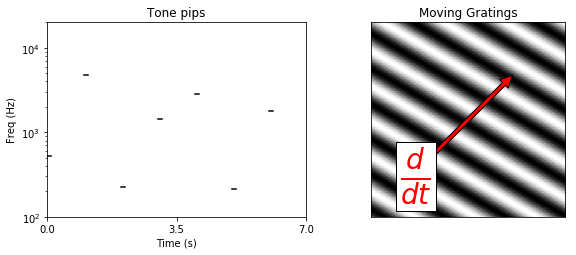

In [117]:
figsize=(9, 4)
f = plt.figure(figsize=figsize)

le = .1
be = .15
re = .1
hg = .1

w1 = .4
w2= 1. - le - re - hg - w1
h = w2 * figsize[0] / figsize[1]

ax0 = f.add_axes([le, be, w1, h])
ax1 = f.add_axes([le + w1 + hg, be, w2, h])


T = 7
ax0.set_title('Tone pips')
ax0.set_xlim(0, T)
ax0.set_xticks([0, T/2., T])
ax0.set_xlabel('Time (s)')

ax0.set_yscale('log')
ax0.set_ylim(1e2, 2e4)
ax0.set_xticks([0, T/2., T])
ax0.set_ylabel('Freq (Hz)')
for ii in range(T):
    f = np.power(10., np.random.uniform(low=np.log10(2e2), high=np.log10(1e4)))
    ax0.plot([ii, ii+.1], [f, f], c='k')

ax1.set_title('Moving Gratings')
ax1.imshow(d['M'][:, :, 0], cmap='gray', extent=[0, 1, 0, 1], aspect='equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.annotate('', xy=(.75, .75), xytext=(.3, .3),
            arrowprops=dict(facecolor='red', shrink=0.05),
            horizontalalignment='center',
            verticalalignment='center',
            )
ax1.text(.15, .15, r'$\frac{d}{dt}$', color='red', size=40,
        bbox=dict(facecolor='white', edgecolor='black'))


plt.savefig('stimuli.pdf', dpi=300)